# Sonar System Object Classification

In this project we apply basic machine learning algorithms to a simple binary classification problem, considering data given by a Sonar System. The aim is to characterize rocks and mines throw the patterns captured by the sonar, each one consists of the measure of energy in a time lapse in different frequencies and varying the angle. We are working within the *MLJ framework* of Julia, which is a compendium of different packages and functions to apply machine learning algorithms.

In [1]:
# Manipulate data
using CSV 
using DataFrames
# Data exploration and visualization
using PrettyPrinting
import Statistics
# Create pseudo-random numbers
using StableRNGs
# Plotting
using StatsPlots

# Statistical Transformations
import StatsBase
import MultivariateStats

# Create and manipulate Categorical Arrays
using CategoricalArrays

### Machine Learning Framework ### 
using MLJ

## 1. Data

### 1.1 Data exploration

In [2]:
# Loading the data
df = CSV.read("sonar.csv",DataFrame)
first(df,3)

,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.228,0.2431,0.3771,0.5598
3,0.01,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598


Note that there are many columns hidden and As we can see, the dataframe does not have a header, so we must built it and load again the data. The first 
columns represent signals (amount of energy) captured by the Sonar, each one in a specific frequency, the last column apparently contains the category labels. 

In [3]:
# Build the header with a list
header = ["Freq$i" for i=1:size(df,2)-1 ]
push!(header,"Label")
# Re Load data and set header
df = CSV.read("sonar.csv",DataFrame,header=header)

# Watch last 7 columns and first 3 rows
first(select(df, 54:61 ),3)

,Freq54,Freq55,Freq56,Freq57,Freq58,Freq59,Freq60,Label
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String1
1,0.0159,0.0072,0.0167,0.018,0.0084,0.009,0.0032,R
2,0.0048,0.0094,0.0191,0.014,0.0049,0.0052,0.0044,R
3,0.0095,0.018,0.0244,0.0316,0.0164,0.0095,0.0078,R


In [4]:
print("Dimension of the DataFrame (cols,rows): \t $(size(df)) 
    \nData Type/Format of the first $(size(df,2)-1) columns: \t $(typeof(df[1,1])) 
    \nData Type/Format of the last column: \t \t $(typeof(df[1,end]))")

Dimension of the DataFrame (cols,rows): 	 (208, 61) 
    
Data Type/Format of the first 60 columns: 	 Float64 
    
Data Type/Format of the last column: 	 	 String1

So we have $N=208$ samples, and the dimension of the feature vector is $D=60$. This could be a problem, because the dimension of the feature vector is high comparing to the amount of samples. This amount of information may not offer additional benefits for optimal decision making, but may rather be complicating and too costly for collection, storage, and processing. In other words, there could noisy features that do not contribute to the reduction of classification errors. So we are going to apply a **PCA as a Dimensionality Reduction Algorithm**.

In [5]:
# Usefull constants
N , D₀ = 208 , 60 ;

Now we are going to describe the distribution of the data for each column using boxplots.

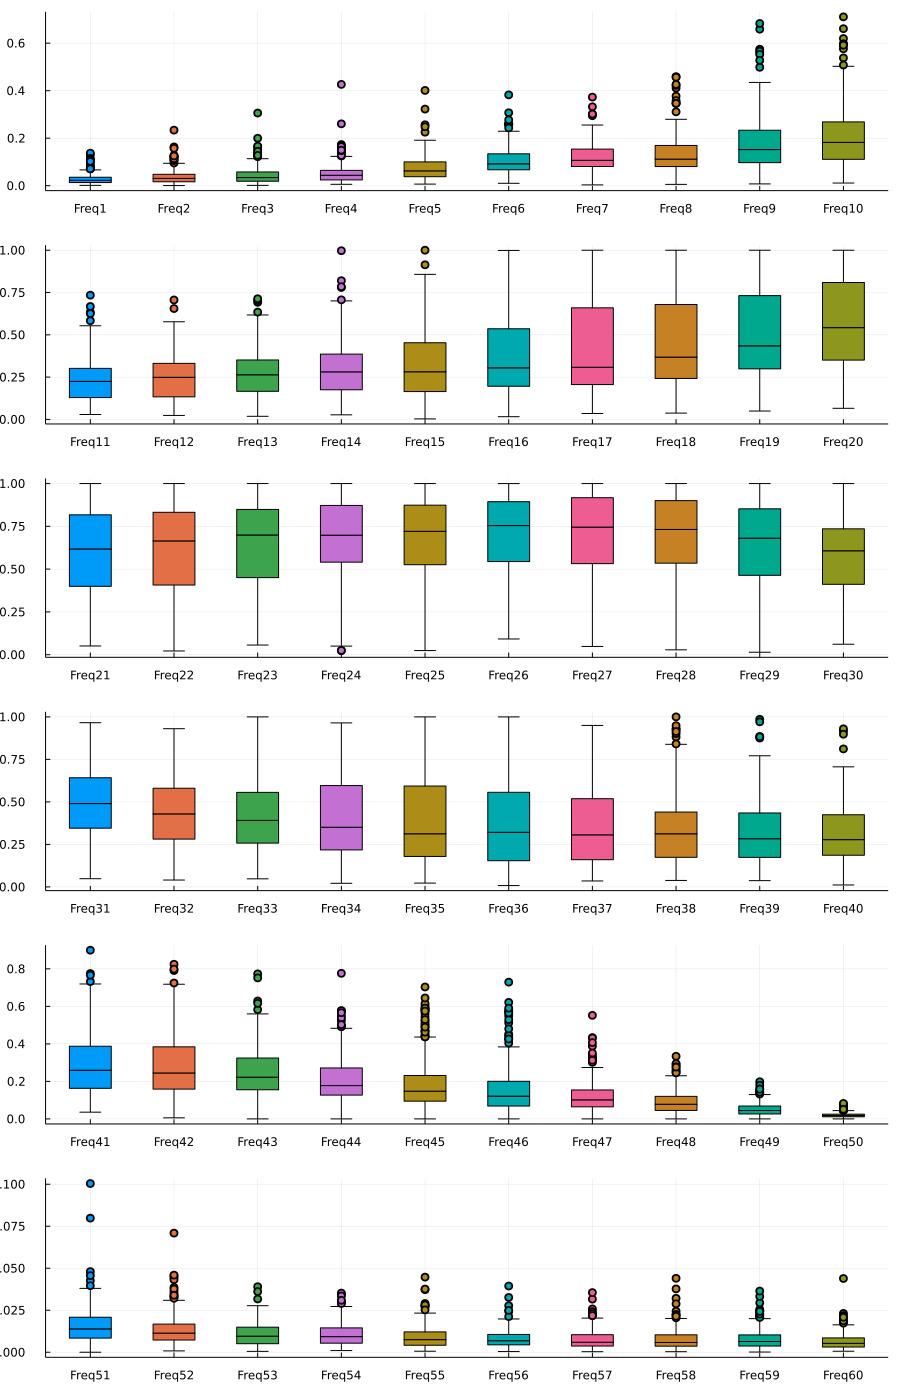

In [6]:
plots=[ boxplot(Array(df[:,i:i+9]), label="",  bar_width=0.5, 
                        xticks=(1:10 , ["Freq$j" for j=i:i+9])) for i in 1:10:51]

plot(plots..., layout=(6,1), size=(900,1400))

From the above graphic we can conclude:
1. The columns could be in the same scale (amount of energy) but they are not in the same range of values, for example, frecuencies 21-30 have greater values than frequencies 51-60. If we apply directly the PCA, the last 10 columns would not give information to the principal components, but they may be crucial to determine differences between rocks and mines. That's why it will be useful to apply Standarization to every single column.
2. There are some outliers (e.g Freq4 and Freq51) that could affect the PCA process, due to it's sensitivity to high variance.

So we shall remove the outliers, then scale each column by standarization and finally apply the PCA algorithm. It is worth mentioning that standarization and PCA reduction are part of the model pipeline, so in order to tune hyperparameters and test model in a realistic way, for the hyperparameter tunning one should fit the standarization and PCA parameters using only the trainning set.

## 2. Dimensionality Reduction
### 2.1 Outliers 
In this procedure we calculate de *Z-Score* of each observartion regarding it's column, any *Z-Score* whose absolute value is greater than 3 is consider as an outlier. After finding an outlier, we replace it with the mean of the column.

In [7]:
# Function to find and replace outliers in a dataframe
function replace_outliers(df)
    outlier_counter = 0 
    for j in 1:size(df,2)
        μ = mean(df[:,j])
        σ = std(df[:,j])
        for i in 1:size(df,1) 
            z = abs((df[i,j]-μ)/σ)
            if z>3
                df[i,j] = μ
                outlier_counter += 1
            end
        end
    end
    print("Outliers found and removed: $outlier_counter")
    return df
end;

In [8]:
# Find and replace outliers
df[:,1:D₀] = replace_outliers(df[:,1:D₀]);

Outliers found and removed: 112

### 2.2 Data Set Split

To make the input-output split (X,y structure) is very easy using the `unpack` function in the MLJ framework.

In [9]:
y, X = unpack(df, ==(:Label));

We are taking 70% of the data for training and the rest for testing. Remember that the amount of rocks and mines is not the same, so we have to guarante that the proportion won't change after the set split. 

The split is done over the data set **indices**, this is the common way in the MLJ framework

In [10]:
# Get rocks indices
rocks_idx = findall(==("R"),y)
# Get mines indices
mines_idx = findall(==("M"),y)

# Set a random seed
rng = StableRNG(0)
# Make a random partition over mines indices 
train_mines , rest_mines = partition( mines_idx , 0.7, shuffle=true, rng=rng)
# Make a random partition over rocks indices 
train_rocks , rest_rocks = partition( rocks_idx , 0.7, shuffle=true, rng=rng)

# Make a random partition over the rest indices 
val_mines, test_mines = partition( rest_mines , 0.5 , shuffle=true, rng=rng)
val_rocks, test_rocks = partition( rest_rocks, 0.5, shuffle=true, rng=rng)


# join mines and rocks (indices) for each set
train = [train_mines ; train_rocks]
validation = [val_mines ; val_rocks]
test = [test_mines ; test_rocks];
print(
"Number of train samples: \t $(length(train)) 
Number of validation samples: \t $(length(validation)) 
Number of test samples: \t $(length(test))")

Number of train samples: 	 146 
Number of validation samples: 	 30 
Number of test samples: 	 32

### 2.3 Transformations

First we fit the standard scaler with the train data, then apply the transformation with fixed parameters to all data

In [11]:
# Standarization 
scaler = StatsBase.fit( StatsBase.ZScoreTransform, Array(X[train,:]) , dims=1);
X_Scaled = StatsBase.transform(scaler, Array(X));

As with the standarization, we fit the PCA transformation with the train data, then apply the transformation with fixed parameters to all data

In [12]:
# PCA proccedure
PCA_transformation = MultivariateStats.fit(MultivariateStats.PCA, X_Scaled[train,:]'; pratio=0.9);
X_transformed = MultivariateStats.transform(PCA_transformation, Array(X)')';

Note that to apply the transformation we had to work with arrays, but in the task of defining ML models is easier to work with dataframes. So the new dataframe with the dimension reduced is:

In [13]:
# The new dimension of feature vector is D
D = size(X_transformed,2)
# New column names
header = ["PC$i" for i=1:D ]
# Turn X_transformed into a DataFrame
X_transformed = DataFrame(Array(X_transformed), header)
first(X_transformed,5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-0.444955,-0.340925,0.832823,1.61939,0.165671,-1.58418,0.383116,-0.398241
2,1.12906,-1.05328,0.850545,1.25368,-0.245004,-0.805779,0.519467,-1.15052
3,0.371064,-0.943686,1.03267,1.55401,-0.0818663,-1.20884,0.77281,-1.24508
4,-0.713462,-0.534201,0.733381,1.22254,0.534696,-1.07452,0.312002,-0.776421
5,0.255416,-0.441507,1.14147,1.03928,-0.273701,-1.08698,0.46209,-0.89718


### 2.4 Bivariate Analysis

Next we present a Scatter plot considering the two principal components, so we can watch the distribution of rocks and mines and it's dependency from PC1 and PC2

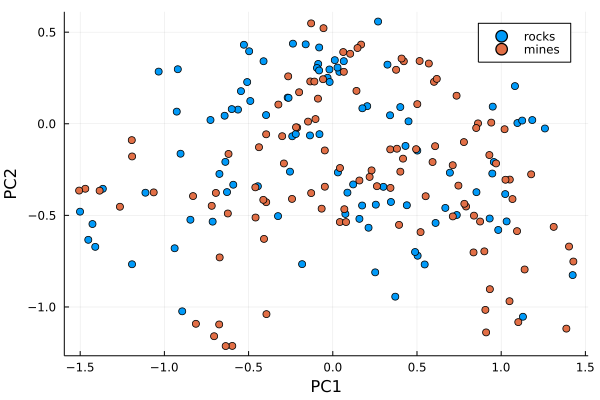

In [14]:
scatter(Array(X_transformed[rocks_idx,1]),Array(X_transformed[rocks_idx,2]), label="rocks")
scatter!(Array(X_transformed[mines_idx,1]),Array(X_transformed[mines_idx,2]), label="mines")
plot!(xlabel="PC1",ylabel="PC2")

### 2.5 Categorical Variables
Before trainning and testing models in the MLJ framework it is required to set appropriately the type for the target variable, which should be categorical. 

In [15]:
y = categorical(y, ordered=true)
typeof(y)

CategoricalVector{String1, UInt32, String1, CategoricalValue{String1, UInt32}, Union{}} (alias for CategoricalArray{String1, 1, UInt32, String1, CategoricalValue{String1, UInt32}, Union{}})

As expected, the categorical labels identified are

In [16]:
levels(y)

2-element Vector{String1}:
 "M"
 "R"

In the model assesment it is appropiate to interpret a mine as "positive" and a rock as "negative", so we ought to define the order $R < M$ 

In [17]:
levels!(y, ["R","M"]);

One can check the order relation.

In [18]:
print("Category of first sample: $(y[1]) \nCategory of last sample: $(y[end])")

Category of first sample: R 
Category of last sample: M

In [19]:
y[1]<y[end]

true

## 3. Hyperparameter Tunning
Now we are ready to train models and tune the hyperparameters using the validation set. In this case, we will set a fixed train-validation partition, this is required by the course in order to understand the differences between working with Cross Validation and a fixed split. In later projects we will apply CrossValidation hyperparameter tunning as it should be to avoid vias given by the specific partition.

### 3.1 Available Models
It is possible to know which models in the MLJ framework are aproppiate for our data, considering the structure $X,y$. This can be done using the function `models` along with the function `matching`. This also helps us to know the right sintaxis to call the models into our script.

In [20]:
for m in models(matching(X_transformed, y))
    println(rpad(m.name, 30), "\t ($(m.package_name))")
end

AdaBoostClassifier            	 (ScikitLearn)
AdaBoostStumpClassifier       	 (DecisionTree)
BaggingClassifier             	 (ScikitLearn)
BayesianLDA                   	 (MultivariateStats)
BayesianLDA                   	 (ScikitLearn)
BayesianQDA                   	 (ScikitLearn)
BayesianSubspaceLDA           	 (MultivariateStats)
ConstantClassifier            	 (MLJModels)
DSADDetector                  	 (OutlierDetectionNetworks)
DecisionTreeClassifier        	 (BetaML)
DecisionTreeClassifier        	 (DecisionTree)
DeterministicConstantClassifier	 (MLJModels)
DummyClassifier               	 (ScikitLearn)
ESADDetector                  	 (OutlierDetectionNetworks)
EvoTreeClassifier             	 (EvoTrees)
ExtraTreesClassifier          	 (ScikitLearn)
GaussianNBClassifier          	 (NaiveBayes)
GaussianNBClassifier          	 (ScikitLearn)
GaussianProcessClassifier     	 (ScikitLearn)
GradientBoostingClassifier    	 (ScikitLearn)
KNNClassifier                 	 (NearestNeighborMode

As we can see, most models are implemented outside of the MLJ ecosystem; we therefore have to load models using the `@load` command and specifying the package where it comes from. 
According to the theory we have seen in the signature, the choosen models are: 
- LinearBinaryClassifier (Linear Regression)
- SVC (Support Vector Machine)
- LogisticClassifier (Logistic Regression)
- DecisionTreeClassifier (Ordinary Desicion Tree) 
- KNeighborsClassifier (K-Nearest Neighbors)

### 3.2 Performance Metric
In classification problems it is common to consider accuracy as the performance measure, it is given by the number of correctly classified examples divided by the total number. But in our case, the data presents class imbalance, using accuracy as performance metric would guide us to wrong interpretations. So, the most adecuate metric is F1-Score, which is the harmonic mean of Precision and Recall. 

Precision is the ratio of correct positive predictions to the overall number of positive predictions

$$Precision = \frac{TP}{TP+FP}$$

Recall is the ratio of correct positive predictions to the overall number of positive examples
in the test or validation set:

$$Recall = \frac{TP}{TP+FN}$$

So F1-Score is given by 
$$F_1 = 2\frac{Precision*Recall}{Precision+Recall}$$

### 3.3 Tuning Technique

In the next sections we will use `TunedModel` with the parameter `resampling` set as `HoldOut()` which means the train-validation structure is fixed. It automatically takes the first rows for training and the rest for validation, given a proportion. So in the next cell we re-order the data considering that fact. 

In [21]:
# Fixed Train-Validation Structure
X_tune = [ X_transformed[train,:] ; X_transformed[validation,:] ]
y_tune= [ y[train] ; y[validation]] ;

For each model we will first specify the hyperparameters to be tuned, based on their impact in the model performance. Then, we use the grid search technique, which consist in define a range for each hyperparameter and train and validate the model with each possible combination of the values in the ranges, finally, the best parameters according to the performance measure are selected. Each model type will be re-trained with those parameters fitting train and validation samples and tested using the test samples, in a further section. 

### 3.4 Linear Regression

In [22]:
# Load model and show the default Hyperparameters
LinearClassifier = @load LinearBinaryClassifier verbosity=0
linear_model = LinearClassifier()

LinearBinaryClassifier(
    fit_intercept = true,
    link = GLM.LogitLink(),
    offsetcol = nothing,
    maxiter = 30,
    atol = 1.0e-6,
    rtol = 1.0e-6,
    minstepfac = 0.001,
    report_keys = [:deviance, :dof_residual, :stderror, :vcov, :coef_table])

In [23]:
# Set the hyperparameters and their ranges
maxiterations = range(linear_model , :maxiter , lower=10, upper=100)
atol_values = range(linear_model , :atol , lower=1.0e-9, upper= 1 , scale=:log)
rtol_values = range(linear_model , :rtol , lower=1.0e-9 , upper= 1 , scale=:log);

The `a_tol` and `r_tol` hyperparameters affects the tolerance of error finding the optimum slopes parameters of the line. The `maxiter` hyperparameter controls the maximum amount of iterations in the optimization solver, which seems to be gradient descent or a variant.

In [24]:
# State a model with self hyperparameter tunning 
self_tunning_linear = TunedModel(model=linear_model, 
                                    resampling=Holdout(fraction_train = 70/85, shuffle=false), # Hold out the rows structure
                                    tuning=Grid(),
                                    range=[maxiterations, atol_values, rtol_values], 
                                    measure=f1score);

# Build a container (machine)
linear_mach = machine(self_tunning_linear, X_tune, y_tune)
# Many Trains and validations variating the hyperparameter
fit!(linear_mach, verbosity=1)
# Get the best hyperparameters
lin_hyp=fitted_params(linear_mach).best_model

# Show the bests hyperparameters found in tunning
print("The best hyperparameters in linear regression for our data are:  
    maxiter: $(lin_hyp.maxiter) 
    atol: $(lin_hyp.atol) 
    rtol: $(lin_hyp.rtol)")

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\JSeba\.julia\packages\MLJBase\CMT6L\src\machines.jl:464
┌ Info: Attempting to evaluate 1000 models.
└ @ MLJTuning C:\Users\JSeba\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 1000 metamodels: 100%[=========================] Time: 0:00:34


The best hyperparameters in linear regression for our data are:  
    maxiter: 10 
    atol: 0.00010000000000000009 
    rtol: 0.10000000000000002

### 3.5 Logistic Regression

In [25]:
# Load the model from the ScikitLearn ecosystem
LogisticClassifier  = @load LogisticClassifier  pkg=ScikitLearn verbosity=0
# Create a model instance with the default hyperparameters
logistic_model = LogisticClassifier()

LogisticClassifier(
    penalty = "l2",
    dual = false,
    tol = 0.0001,
    C = 1.0,
    fit_intercept = true,
    intercept_scaling = 1.0,
    class_weight = nothing,
    random_state = nothing,
    solver = "lbfgs",
    max_iter = 100,
    multi_class = "auto",
    verbose = 0,
    warm_start = false,
    n_jobs = nothing,
    l1_ratio = nothing)

In [26]:
# Set the hyperparameters and their ranges
penalty = range( logistic_model, :penalty, values=["none", "l1", "l2", "elasticnet"])
C_range = range( logistic_model, :C , lower=0.001, upper=10, scale=:log)
solvers = range( logistic_model, :penalty, values=["newton-cg", "lbfgs", "liblinear", "sag", "saga"]);

Penalty, also known as regularization technique, is the process of adding new information to avoid overfitting. 
C controls the strenght of the penalty. 
There are many solvers for the optimization prolem, the solver convergence could affect the model.

In [27]:
# State a model with self hyperparameter tunning 
self_tunning_logReg = TunedModel(model=logistic_model, 
                                      resampling=Holdout(), 
                                      tuning=Grid(),
                                      range=C_range, 
                                      measure=f1score);

# Build a container (machine)
logReg_mach = machine(self_tunning_logReg, X_tune, y_tune)
# Many Trains and validations variating the hyperparameters
fit!(logReg_mach, verbosity=1);
# Store best parameters
logReg_hyp = fitted_params(logReg_mach).best_model

# Show the bests hyperparameters found in tunning
print("The best hyperparameters in Logistic Regression for the data are:  
    Penalty: $(logReg_hyp.penalty) 
    C: $(logReg_hyp.C) 
    solver: $(logReg_hyp.solver)")

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\JSeba\.julia\packages\MLJBase\CMT6L\src\machines.jl:464
┌ Info: Attempting to evaluate 10 models.
└ @ MLJTuning C:\Users\JSeba\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 10 metamodels: 100%[=========================] Time: 0:00:05


The best hyperparameters in Logistic Regression for the data are:  
    Penalty: l2 
    C: 10.000000000000002 
    solver: lbfgs

### 3.6 Support Vector Machine

In [28]:
# Load model and show the default Hyperparameters
SVC = @load SVC verbosity=0 pkg=LIBSVM
svc_model = SVC()

SVC(
    kernel = LIBSVM.Kernel.RadialBasis,
    gamma = 0.0,
    cost = 1.0,
    cachesize = 200.0,
    degree = 3,
    coef0 = 0.0,
    tolerance = 0.001,
    shrinking = true,
    probability = false)

In [29]:
# This pkg contains a module with kernel functions  
import LIBSVM

# Set the hyperparameters and their ranges
kernels = range( svc_model , :kernel, values=[LIBSVM.Kernel.Polynomial, LIBSVM.Kernel.Linear, LIBSVM.Kernel.Sigmoid, LIBSVM.Kernel.RadialBasis] )
gamma_values = range(svc_model, :gamma, lower = 0.1, upper = 10, scale=:log)
cost_values = range(svc_model, :cost, lower = 0.1, upper = 10, scale=:log);

┌ Warning: Inferring the hyper-parameter type from the given model instance as the corresponding field is typed `Any`.
└ @ MLJBase C:\Users\JSeba\.julia\packages\MLJBase\CMT6L\src\hyperparam\one_dimensional_ranges.jl:120


The cost, also called Regularization Hyperparameter, controls the impact of noisy data on th hiperplane margin. The higher the cost, the better the margin; the lower the cost, the best fit to noisy (non-separable) points.
The kernels are diferent functions to transform the data when it is not sepparable, the Radial Basis Function Kernel is widely used, and it has a especial parameter gamma which controls the smoothness of decisition boundary curve.

In [30]:
# State a model with self hyperparameter tunning 
self_tunning_svc = TunedModel(model=svc_model, 
                                    resampling=Holdout(fraction_train=70/85, shuffle=false), # Holdout the Structure of rows. 
                                    tuning=Grid(),
                                    range=[kernels, cost_values, gamma_values], 
                                    measure=f1score); # set the preformance metric

# Build a container (machine)
svc_mach = machine(self_tunning_svc, X_tune, y_tune)
# Many Trains and validations variating the hyperparameters
fit!(svc_mach, verbosity=1);
# Store best parameters
svc_hyp = fitted_params(svc_mach).best_model

# Show the bests hyperparameters found in tunning
print("The best hyperparameters in SVC for our data are:  
    kernel: $(svc_hyp.kernel) 
    gamma: $(svc_hyp.gamma) 
    cost: $(svc_hyp.cost)")

┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\JSeba\.julia\packages\MLJBase\CMT6L\src\machines.jl:464
┌ Info: Attempting to evaluate 400 models.
└ @ MLJTuning C:\Users\JSeba\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 400 metamodels: 100%[=========================] Time: 0:00:09


The best hyperparameters in SVC for our data are:  
    kernel: RadialBasis 
    gamma: 1.291549665014884 
    cost: 5.994842503189412

### 3.6 Nearest Neighbors

In [31]:
# Load knn from Scikit ecosystem
KNN = @load KNeighborsClassifier  verbosity=0;
print("KNN default parameters:")
# Create instance of the model
knn_model = KNN()

KNN default parameters:

KNeighborsClassifier(
    n_neighbors = 5,
    weights = "uniform",
    algorithm = "auto",
    leaf_size = 30,
    p = 2,
    metric = "minkowski",
    metric_params = nothing,
    n_jobs = nothing)

In [32]:
k = range(knn_model, :n_neighbors, lower=1, upper=21)
metrics = range(knn_model, :metric, values=["euclidean", "manhattan", "minkowski"])
weights_values = range(knn_model, :weights, values=["uniform", "distance"])

┌ Warning: Inferring the hyper-parameter type from the given model instance as the corresponding field is typed `Any`.
└ @ MLJBase C:\Users\JSeba\.julia\packages\MLJBase\CMT6L\src\hyperparam\one_dimensional_ranges.jl:120


NominalRange(weights = uniform, distance)

`k` is the number of nearest neighbors to take the decisition, it must be and odd number.

`metric` is the distance measure to determine which points are near from a specific sample.

It is posible to variate the contribution of members of the neighborhood via different weightings with the hyperparameter `weights` 

In [33]:
self_tunning_knn = TunedModel(model=knn_model, 
                                    resampling=Holdout(), 
                                    tuning=Grid(),
                                    range=[k, metrics, weights_values], 
                                    measure=f1score)
# Build a container (machine)
knn_mach = machine(self_tunning_knn, X_tune, y_tune)
# Many Trains and validations variating the hyperparameters
fit!(knn_mach, verbosity=1);
# Store best parameters
knn_hyp = fitted_params(knn_mach).best_model

# Show the bests hyperparameters found in tunning
print("The best hyperparameters in KNN for our data are:  
    k_neighbours: $(knn_hyp.n_neighbors) 
    metric: $(knn_hyp.metric) 
    weights: $(knn_hyp.weights)")

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\JSeba\.julia\packages\MLJBase\CMT6L\src\machines.jl:464
┌ Info: Attempting to evaluate 60 models.
└ @ MLJTuning C:\Users\JSeba\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 60 metamodels: 100%[=========================] Time: 0:00:02


The best hyperparameters in KNN for our data are:  
    k_neighbours: 1 
    metric: manhattan 
    weights: uniform

### 3.7 Decision Tree

In [34]:
# Load the model from DecisionTree ecosystem
DecisionTreeClassifier = @load DecisionTreeClassifier pkg=DecisionTree  verbosity=0
print("Default hyperparameters are: ")
# Create in instance of the model with the default parameters
tree_model = DecisionTreeClassifier()

Default hyperparameters are: 

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0,
    display_depth = 5,
    rng = Random._GLOBAL_RNG())

In [35]:
# Set hyperparameters and ranges
depths = range(tree_model, :max_depth , lower=2 , upper=20)
leafs = range(tree_model, :min_samples_leaf , lower=1 , upper=10)
splits = range(tree_model, :min_samples_split , lower=1 , upper=10)
subfeatures = range(tree_model, :n_subfeatures , lower=0 , upper=3);

`max depth` is the maximum number of layers of the tree.

`min samples leaf` indicates the minimum number of samples required to be at a leaf node.

`min samples split` is the minimum number of samples in a leaf to be splited

In [36]:
self_tunning_tree = TunedModel(model=tree_model, 
                                    resampling=Holdout(), 
                                    tuning=Grid(),
                                    range=[depths,leafs,splits,subfeatures], 
                                    measure=f1score);

In [37]:
tree_mach = machine(self_tunning_tree, X_tune, y_tune)
fit!(tree_mach, verbosity=1);
tree_hyp=fitted_params(tree_mach).best_model
# Show the bests hyperparameters found in tunning
print("The best hyperparameters in Decistion Tree for our data are:  
    max depth: $(tree_hyp.max_depth) 
    min samples leaf: $(tree_hyp.min_samples_leaf) 
    min samples split: $(tree_hyp.min_samples_split)
    subfeatures: $(tree_hyp.n_subfeatures)")

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\JSeba\.julia\packages\MLJBase\CMT6L\src\machines.jl:464
┌ Info: Attempting to evaluate 4000 models.
└ @ MLJTuning C:\Users\JSeba\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 4000 metamodels: 100%[=========================] Time: 0:00:14


The best hyperparameters in Decistion Tree for our data are:  
    max depth: 18 
    min samples leaf: 1 
    min samples split: 5
    subfeatures: 2

## 4. Model Comparison 
In this last section we are going to Train each of the 5 models selected, considering the hyperparameters found in section 3, over the samples that belongs to train and validation sets. Because we re-train, we also should fit and apply again the transformations, standarization and PCA, using the samples from train and validation sets. We will compare the models using the same performance metric F1Score and then we will analyse a the best model a bit further.

In [38]:
# Set the indices of rows for the "re-train"
second_train = [train ; validation];

### 4.1 Transformations fitting Train & Validation samples

In [39]:
# Standarization 
scaler = StatsBase.fit( StatsBase.ZScoreTransform, Array(X[second_train,:]) , dims=1);
X_Scaled = StatsBase.transform(scaler, Array(X));

# PCA Transformation
PCA_transformation = MultivariateStats.fit(MultivariateStats.PCA, X_Scaled[second_train,:]'; pratio=0.9);
X_transformed = MultivariateStats.transform(PCA_transformation, Array(X)')';

# The new dimension of feature vector is D
D = size(X_transformed,2)
# New column names
header = ["PC$i" for i=1:D ]
# Turn X_transformed into a DataFrame
X_transformed = DataFrame(Array(X_transformed), header);

### 4.2 State Models with fixed Hyperparameters from the tuning.

In [40]:
# Create model instances with the best hyperparameters found for each one

# Linear Regression
best_linear = LinearClassifier(maxiter=lin_hyp.maxiter,
                               atol=lin_hyp.atol,
                               rtol=lin_hyp.rtol)

# Logistic Regression
best_logistic = LogisticClassifier(penalty=logReg_hyp.penalty,
                                   C=logReg_hyp.C,
                                   solver=logReg_hyp.solver)

# Suport vector machine
best_svc = SVC(kernel=svc_hyp.kernel, 
               gamma=svc_hyp.gamma, 
               cost=svc_hyp.cost)

# K Nearest Neighrbors
best_knn = KNN(n_neighbors=knn_hyp.n_neighbors, 
               weights=knn_hyp.weights, 
               metric=knn_hyp.metric)

# Decision Tree
best_tree = DecisionTreeClassifier(max_depth=tree_hyp.max_depth,
                                    min_samples_leaf=tree_hyp.min_samples_leaf,
                                    min_samples_split=tree_hyp.min_samples_split,
                                    n_subfeatures=tree_hyp.n_subfeatures);

### 4.3 Train, test and evaluate

In [41]:
instances = [best_linear, best_logistic, best_svc, best_knn, best_tree]

# Create an array to save the scores
scores = []
# Main cycle to train, predict and evaluate every model.
for instance in instances
    mach = machine(instance, X_transformed , y)
    fit!(mach, rows=second_train, verbosity=0)
    
    # Consider If the model has a probabilistic output or not. 
    # For further information about probabilistic output on MLJ see 1.Basic Models(first delivery) -> Section 3.2
    if instance == best_svc
        ŷ = predict(mach, rows=test)
    else
        ŷ = predict_mode(mach, rows=test)
    end
    
    # Evaluating the model perfomance by f1score metric
    f1_score = f1score(ŷ, y[test])
    println("\t Score: $(round(f1_score, digits=4)) \t \t  ----->  $(instance)")
    push!(scores,f1_score)
end

	 Score: 0.8824 	 	  ----->  LinearBinaryClassifier
	 Score: 0.8421 	 	  ----->  LogisticClassifier
	 Score: 0.8889 	 	  ----->  SVC
	 Score: 0.7879 	 	  ----->  KNeighborsClassifier
	 Score: 0.7879 	 	  ----->  DecisionTreeClassifier


### 4.4 Best Model

In [42]:
# Find model with highest score
best_model = instances[findmax(scores)[2]]
model_name  = string(best_model)
print("The best model is $model_name")

The best model is SVC

### 4.4.1 Fitting Analysis

In [43]:
# Model training and prediction on train set to see fitting behavior
mach = machine(best_model, X_transformed , y)
fit!(mach, rows=train, verbosity=0)
ŷtrain = predict(mach, rows=second_train);


The confussion matrix for the trainning set is

In [44]:
display(confmat(ŷtrain,y[second_train]))

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      R      │      M      │
├─────────────┼─────────────┼─────────────┤
│      R      │     82      │      2      │
├─────────────┼─────────────┼─────────────┤
│      M      │      0      │     92      │
└─────────────┴─────────────┴─────────────┘


In [45]:
# Compue accuracy and f1 score on the TRAIN set.
accuracy_train = accuracy(ŷtrain,y[second_train])
f1_train = f1score(ŷtrain, y[second_train])
print("Fitting Accuracy: \t $accuracy_train \nFitting F1Score: \t $f1_train")

Fitting Accuracy: 	 0.9886363636363636 
Fitting F1Score: 	 0.989247311827957

We can see that the fitting accuracy is almost 99%, which means that the fitting is quite perfect, there are 2 false negatives and 0 false positives. However, it reachs 98% in f1score, which is the choosen metric, this might be an explanation of model's succes.

### 4.4.2 Performance on the test Data

In [46]:
# Prediction by the model on the test data
ŷtest = predict(mach, rows=test);

Confussion Matrix:

In [47]:
display(confmat(ŷtest,y[test]))

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      R      │      M      │
├─────────────┼─────────────┼─────────────┤
│      R      │     13      │      2      │
├─────────────┼─────────────┼─────────────┤
│      M      │      2      │     15      │
└─────────────┴─────────────┴─────────────┘


In [48]:
# Compute usefull metrics between predictions and actual categories.
accuracy_test = accuracy(ŷtest,y[test])
recall_test = recall(ŷtest,y[test])
precision_test = precision(ŷtest,y[test])
f1_score_test = f1score(ŷtest,y[test])
print("Model Accuracy: \t $accuracy_test 
Model Recall: \t \t $recall_test 
Model Precision: \t $precision_test
Model F1-Score: \t $f1_score_test")

Model Accuracy: 	 0.875 
Model Recall: 	 	 0.8823529411764706 
Model Precision: 	 0.8823529411764706
Model F1-Score: 	 0.8823529411764706

Over the 32 samples intented for testing the model,the SVM classified well 28 of them and 4 poorly. We have 2 false negatives mines and 2 false positives rocks, which tells us that there were not class bias, for the classifier recall and precision have the same importance, this is expected because at the hyperparameter tunning and final election we used the F1-Score which is armonic mean between recall and precision. In conclusion, we build a ML-pipeline which includes dimensionality reduction by PCA along with a support vector machine that fits almost perfect the train data and has a very well performance on unknown data (88%), so it has a good generalzation capability. 